# Sentinel 2 Fractional Cover

## Code to query the Element84 STAC and drill out the Sentinel sites
Uses [Pixel Driller](https://pixeldriller.readthedocs.io/en/latest/) for the heavy lifting.

Star transects downloaded from the [Field Data Portal](https://field.jrsrp.com/)

In [ ]:
import pandas as pd
import numpy as np
import datetime
from pixdrill import drillpoints
from pixdrill import drill
from pixdrill import drillstats
from tqdm import tqdm  # Import tqdm for the progress bar

# Read the CSV file into a DataFrame
in_df = pd.read_csv('star_transects.csv')

# Get the relevant columns: FID, ref_x, ref_y, and obs_time
df = in_df[['FID', 'ref_x', 'ref_y', 'obs_time']]

# Define constants
crs_code = 4326  # EPSG code for WGS84 coordinate reference system
t_delta = datetime.timedelta(days=15)  # 15 days either side
site_shape = drillpoints.ROI_SHP_CIRCLE  # Define the extraction shape
site_radius = 50  # In meters

# Secondly, the STAC catalogue and raster assets of the STAC Items.
endpoint = "https://earth-search.aws.element84.com/v1"
collections = ['sentinel-2-l2a']
assets = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'swir16', 'swir22', 'scl']

def user_median(array_info, item, pt):
    return [float(np.median(a_info.data.compressed() if np.ma.is_masked(a_info.data) else a_info.data)) for a_info in array_info]

def user_sclgood(array_info, item, pt):
    target_values = {4, 5, 6, 7, 11}
    stats = []
    for a_info in array_info:
        data = a_info.data.compressed() if np.ma.is_masked(a_info.data) else a_info.data
        count_good_pixels = np.isin(data, list(target_values)).sum()
        stats.append(count_good_pixels / len(data))
        
    return [float(stat) for stat in stats]

std_stats = [drillstats.STATS_MEAN, drillstats.STATS_STDEV, drillstats.STATS_COUNT]
user_stats = [("sclgood", user_sclgood)]

# Initialize an empty list for storing results
data = []

# Iterate over each row in the DataFrame with a progress bar
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Points"):
    longitude = row['ref_x']
    latitude = row['ref_y']
    
    # Parse the observation time string into a datetime object
    date = datetime.datetime.strptime(row['obs_time'], "%Y-%m-%dT%H:%M:%S")
    # Check that the date is greater than 23 June 2015
    if date < datetime.datetime(2015, 6, 23):
        continue

    # Create a Point object with information from the current row
    pt = drillpoints.Point(longitude, latitude, date, crs_code, t_delta, site_radius, site_shape)
    # Set the FID attribute of the Point object in pt.items
    pt.items['FID'] = row['FID']
    
    # Drill the point immediately
    drill.drill(
        [pt],  # Pass the single point in a list
        stac_endpoint=endpoint,
        raster_assets=assets,
        collections=collections,
        std_stats=std_stats,
        user_stats=user_stats
    )
    
    # Process the stats for this point
    for item_id, item_stats in pt.stats.get_stats().items():
        scl_percent = item_stats['sclgood'][-1]
        if scl_percent < 1.0:
            continue
        fid = pt.items['FID']
        sat_date = datetime.datetime.strptime(item_id.split('_')[2], "%Y%m%d").isoformat()
        mean_values = item_stats[drillstats.STATS_MEAN]
        stdev_values = item_stats[drillstats.STATS_STDEV]
        count_values = item_stats[drillstats.STATS_COUNT]
        data.append([fid, item_id, sat_date, mean_values, stdev_values, count_values])

out_df = pd.DataFrame(data, columns=['FID', 'item_id', 'sat_date', 'means', 'stdevs', 'counts'])
# Save the DataFrame
out_df.to_pickle('out_df.pkl')
# Print the DataFrame
print(out_df)
# Print the number of rows in the DataFrame
print(f"Number of rows: {len(out_df)}")

# Join the dataframes on the FID column noting that the out_df will be on the left and multiple rows will be returned
joined_df = out_df.merge(in_df, on='FID', how='left')
# Save the joined DataFrame
joined_df.to_pickle('joined.pkl')

## Fractional Cover Calibration Steps

In [199]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Use dark style for plots
plt.style.use('dark_background')


print("TensorFlow v"+tf.__version__)
print(tf.test.gpu_device_name())


def fractionalCoverSatView(df):
    """
    Calculate fractional cover as viewed from a satellite based on intercept data from a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the necessary columns:
        - 'num_points', 'unoccluded', 'over_b', 'over_d', 'over_g', 'crn',
          'mid_b', 'mid_g', 'mid_d', 'dead', 'litter', 'crust', 'dist',
          'rock', 'green', 'crypto'.

    Returns:
    tuple of np.ndarray: Six NumPy arrays, each representing one of the calculated cover metrics.
    """
    
    totalPVCover_list = []
    totalNPVCover_list = []
    totalBareCover_list = []
    totalCryptoCover_list = []
    satPersistentGreen_list = []
    persistentNPVFraction_list = []

    for _, row in df.iterrows():
        nTotal = row['num_points']
        nUnoccluded = row['unoccluded']
        
        # Canopy Layer
        nCanopyBranch = row['over_b'] * nTotal / 100.0
        nCanopyDead = row['over_d'] * nTotal / 100.0
        nCanopyGreen = row['over_g'] * nTotal / 100.0
        
        # Midstory Layer
        nMidBranch = row['mid_b'] * nTotal / 100.0
        nMidGreen = row['mid_g'] * nTotal / 100.0
        nMidDead = row['mid_d'] * nTotal / 100.0
        
        # Ground Layer
        nGroundDeadLitter = (row['dead'] + row['litter']) * nUnoccluded / 100.0
        nGroundCrustDistRock = (row['crust'] + row['dist'] + row['rock']) * nUnoccluded / 100.0
        nGroundGreen = row['green'] * nUnoccluded / 100.0
        nGroundCrypto = row['crypto'] * nUnoccluded / 100.0
        
        # Calculations
        canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
        canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
        canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
        canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
        
        midFoliageProjectiveCover = nMidGreen / nTotal
        midDeadProjectiveCover = nMidDead / nTotal
        midBranchProjectiveCover = nMidBranch / nTotal
        midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
        
        satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
        satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
        
        groundPVCover = nGroundGreen / nUnoccluded
        groundNPVCover = nGroundDeadLitter / nUnoccluded
        groundBareCover = nGroundCrustDistRock / nUnoccluded
        groundCryptoCover = nGroundCrypto / nUnoccluded
        groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
        
        satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
        
        totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
        totalNPVCover = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                         satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover)
        totalBareCover = satGroundBareCover
        totalCryptoCover = satGroundCryptoCover
        
        satPersistentGreen = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover
        persistentNPVFraction = (canopyDeadProjectiveCover + canopyBranchProjectiveCover +
                                 satMidDeadProjectiveCover + satMidBranchProjectiveCover)

        totalPVCover_list.append(totalPVCover)
        totalNPVCover_list.append(totalNPVCover)
        totalBareCover_list.append(totalBareCover)
        totalCryptoCover_list.append(totalCryptoCover)
        satPersistentGreen_list.append(satPersistentGreen)
        persistentNPVFraction_list.append(persistentNPVFraction)

    return (
        np.array(totalPVCover_list),
        np.array(totalNPVCover_list),
        np.array(totalBareCover_list),
        np.array(totalCryptoCover_list),
        np.array(satPersistentGreen_list),
        np.array(persistentNPVFraction_list),
    )


TensorFlow v2.17.0
/device:GPU:0


I0000 00:00:1737602765.190521  177651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737602765.191945  177651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737602765.193082  177651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737602765.194208  177651 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Load the Sentinel 2 data associated with the Star Transect sites

This opens the dataframe, filters by SCL, selects a maximum of two closest dates, and applies the function to recover the fractional cover values from the field data.

In [225]:



# Read joined.pkl as a pandas DataFrame
df = pd.read_pickle('joined.pkl')
# Remove all the rows where the last element (SCL) in the means column is not 5
df = df[df['means'].apply(lambda x: x[-1] == 5)]
# Remove all the rows where there is no field data
df = df.dropna(subset=['unoccluded', 'over_b', 'over_d', 'over_g', 'crn', 'mid_b', 'mid_g', 'mid_d', 'dead', 'litter', 'crust', 'dist', 'rock', 'green', 'crypto'])
# Calculate a new column called days_diff which is the difference between the obs_time and the sat_date strings
df['days_diff'] = (pd.to_datetime(df['obs_time']) - pd.to_datetime(df['sat_date'])).dt.days
# Print the number of rows
print(df.shape[0])
# Select the closest 2 observations for each FID
# df = df.sort_values('days_diff').groupby('FID').head(2)


# Select all the observations  for the two closest dates for each FID
# This is picking up the overlaps between tiles and processing versions
df = df.sort_values(['FID', 'days_diff'])
# Function to get the closest dates
def get_closest_dates(sub_df):
    # Select the closest two dates for each FID
    closest_dates = sub_df.nsmallest(2, 'days_diff', keep='all')['sat_date'].unique()
    return sub_df[sub_df['sat_date'].isin(closest_dates)]


df = df.groupby('FID', group_keys=False).apply(get_closest_dates)


# Print the number of rows
print(df.shape[0])
# Find the unique values of the FID column
FIDs = df['FID'].unique()
# Print the counts of the unique values ordered from the most to the least frequent
print(df['FID'].value_counts())
# Add the counts to the DataFrame
df['FID_counts'] = df['FID'].map(df['FID'].value_counts())


# Calculate fractional cover as viewed from a satellite based on intercept data   
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(df)
      
# Extract the Sentinel 2 reflectance from the means column of the DataFrame
refData = df['means'].apply(pd.Series).values
# Drop the last column (SCL)
refData = refData[:, :-1] / 10000
# Extract the weights from the FID_counts column of the DataFrame
weights = 1/df['FID_counts'].values

print(f"Number of sites: {len(totalPVCover)}")




11450


/tmp/ipykernel_177651/1943804249.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('FID', group_keys=False).apply(get_closest_dates)


2966
FID
star_transects.fid-35735e87_1942a663648_-6c73    8
star_transects.fid-35735e87_1942a663648_-712d    8
star_transects.fid-35735e87_1942a663648_-6e9e    8
star_transects.fid-35735e87_1942a663648_-6dbc    8
star_transects.fid-35735e87_1942a663648_-6e9a    8
                                                ..
star_transects.fid-35735e87_1942a663648_-7125    1
star_transects.fid-35735e87_1942a663648_-7137    1
star_transects.fid-35735e87_1942a663648_-714b    1
star_transects.fid-35735e87_1942a663648_-7087    1
star_transects.fid-35735e87_1942a663648_-708f    1
Name: count, Length: 1302, dtype: int64
Number of sites: 2966


#### Have a look at the reflectance spread for a single field site

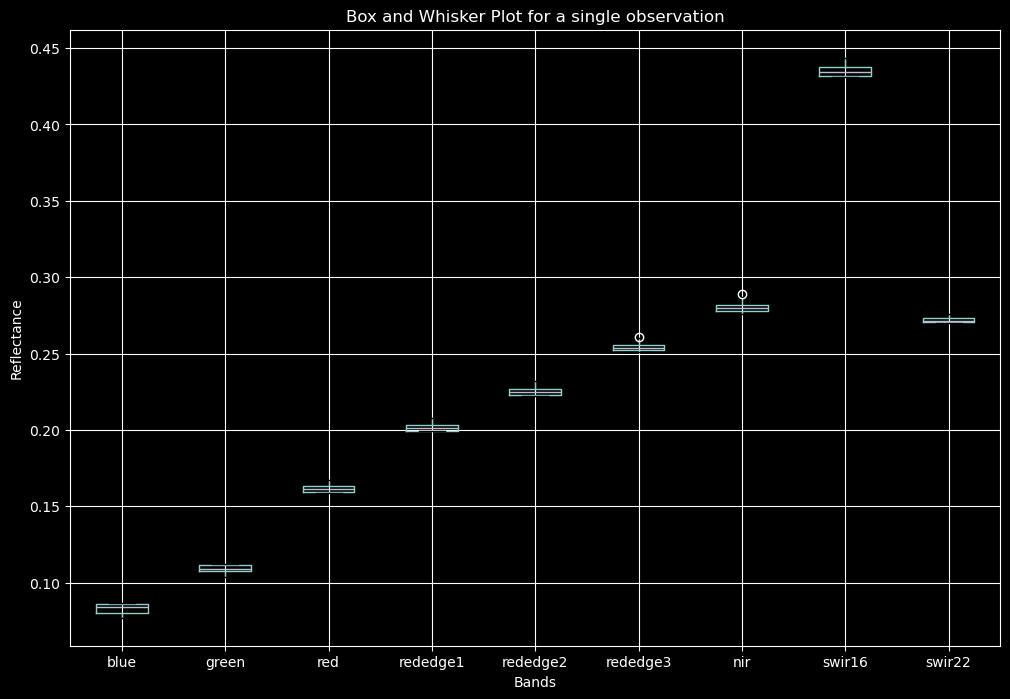

In [226]:
# Plot the number of observations per FID
# Select rows where FID = star_transects.fid-35735e87_1942a663648_-7231 and sat_date = 2019-06-01T00:00:00
df_means = df[(df['FID'] == 'star_transects.fid-35735e87_1942a663648_-6e9a')]['means'].apply(pd.Series)
df_means.columns = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'swir16', 'swir22', 'scl']
# Drop SCL column
df_means = df_means.drop(columns='scl')
# Divide by 10000 to get reflectance
df_means = df_means / 10000
# Plotting
plt.figure(figsize=(12, 8))
df_means.boxplot()
plt.title('Box and Whisker Plot for a single observation')
plt.ylabel('Reflectance')
plt.xlabel('Bands')
plt.show()


### Plot the Green field data

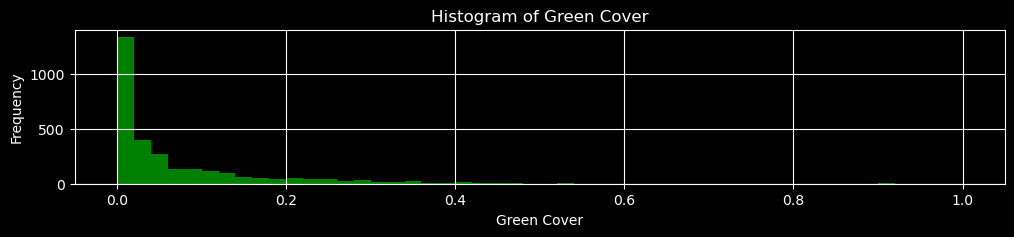

In [227]:
plt.figure(figsize=(12, 2))
# Plot a histogram of cryptogam cover
plt.hist(totalPVCover, bins=50, color='green')
plt.title('Histogram of Green Cover')
plt.xlabel('Green Cover')
plt.ylabel('Frequency')
plt.grid()

## Iteration 1 - Minimal Prediction to assign crypto and detect outliers
The next problem to address is field labeling issues.  
First, cryptogram (or biological soil crusts) are not assigned a "colour" and we need to decide whether to treat them as green or non green. We do this by doing a rough model fit, and then testing where the cryptogram component for each sit best fits.  

For this model, we don't apply a sum to one as the crypto is missing.

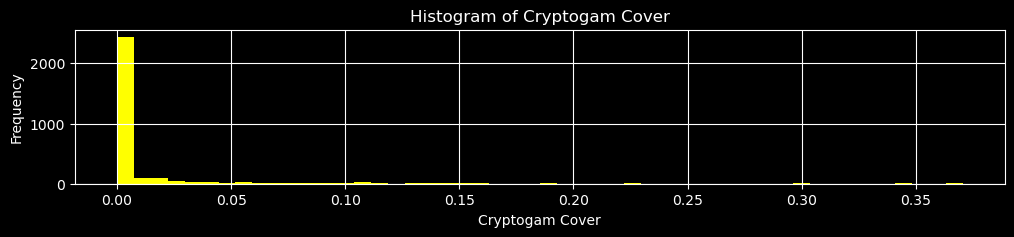

In [ ]:
plt.figure(figsize=(12, 2))
# Plot a histogram of cryptogam cover
plt.hist(totalCryptoCover, bins=50, color='yellow')
plt.title('Histogram of Cryptogam Cover')
plt.xlabel('Cryptogam Cover')
plt.ylabel('Frequency')
plt.grid()

In [229]:
# Set up the data for training
train_labels = np.transpose([totalBareCover, totalPVCover, totalNPVCover])
train_dataset = refData.copy()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3), input_shape=[train_dataset.shape[1]]),
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3)),
    tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3)),
    tf.keras.layers.Dense(3)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Custom callback for tqdm progress bar
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.params['epochs'], desc="Training Progress", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Fit the Model
history = model.fit(train_dataset, train_labels,
                    epochs=2500,
                    validation_split=0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=8192,
                    callbacks=[TQDMProgressBar()])

allPredictions = model.predict(train_dataset)
predNongreenCover = allPredictions[:, 2]
predGreenCover = allPredictions[:, 1]
predBareCover = allPredictions[:, 0]


/home/ubuntu/miniforge3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/2500 [00:00<?, ?epoch/s]

Training Progress: 100%|██████████| 2500/2500 [01:58<00:00, 21.07epoch/s]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Guess the cryptogram class by assigning to the class that gives the best fit
Dodgy as, but I can't think of a better method

In [230]:
# Assign the crypto to the class that improves the error the most    
greenError  = predGreenCover - totalPVCover
nongreenError = predNongreenCover-totalNPVCover

cryptoNongreenIDX = (np.abs(nongreenError) >= np.abs(nongreenError-totalCryptoCover))
cryptoGreenIDX = (np.abs(nongreenError) < np.abs(nongreenError-totalCryptoCover))
totalPVCover[cryptoGreenIDX] = totalPVCover[cryptoGreenIDX] + totalCryptoCover[cryptoGreenIDX]
totalNPVCover[cryptoNongreenIDX] = totalNPVCover[cryptoNongreenIDX] + totalCryptoCover[cryptoNongreenIDX]


print("Nongreen crypto samples = %f" %np.sum(cryptoNongreenIDX))
print("Green crypto samples = %f" %np.sum(cryptoGreenIDX))



Nongreen crypto samples = 2540.000000
Green crypto samples = 426.000000


### Remove potential outliers
There are some outliers in the field data. These seem to be some of the early CHAT sites and also those sites where the groundcover has changes significantly in the days between the measurement.

We detect these by finding those sites where the prediction error is more than 3 standard deviations from zero.

Retaining 2917 Sites


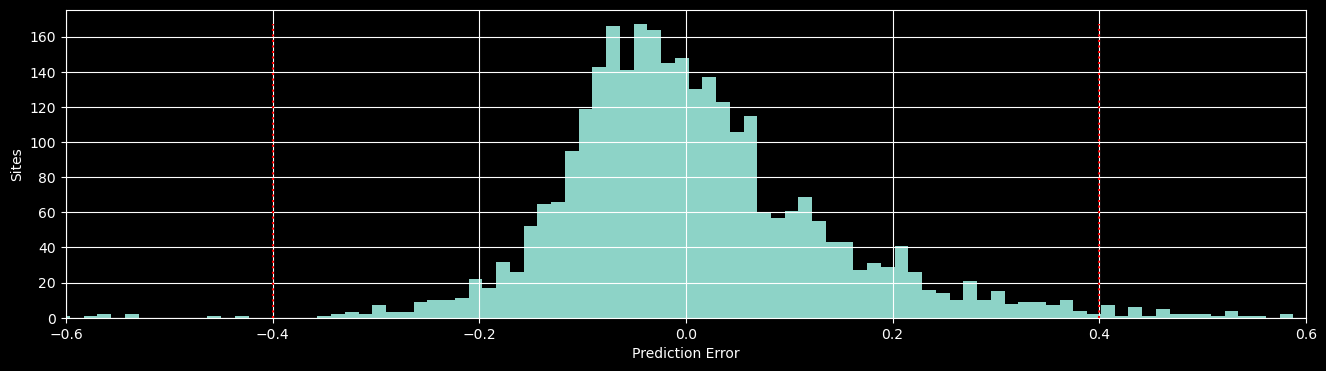

In [231]:
# Find any wild outliers - Typically early CHAT sites or sites where rainfall or grazing rapidly changed the surface
barePredictionError= totalBareCover-predBareCover
anomalyCutoff = np.std(barePredictionError) * 3.0
isNotOutlierIDX = np.where(np.abs(barePredictionError) < anomalyCutoff)
print(f'Retaining {len(isNotOutlierIDX[0])} Sites')
totalBareCover = np.array(totalBareCover)[isNotOutlierIDX]
totalPVCover = np.array(totalPVCover)[isNotOutlierIDX]
totalNPVCover = np.array(totalNPVCover)[isNotOutlierIDX]
persistentNPVFraction = np.array(persistentNPVFraction)[isNotOutlierIDX]
satPersistentGreen = np.array(satPersistentGreen)[isNotOutlierIDX]
refData = refData[isNotOutlierIDX]

# Plot the cutoffs
plt.figure(figsize=(16,4))
histData = plt.hist(barePredictionError,bins=100)
plt.xlabel('Prediction Error')
plt.ylabel('Sites')
plt.plot([-anomalyCutoff,-anomalyCutoff],[0,np.max(histData[0])],':r')
plt.plot([anomalyCutoff,anomalyCutoff],[0,np.max(histData[0])],':r')
plt.xlim([-0.6,0.6])
plt.grid()
#plt.savefig('../paper/anomaly.png', bbox_inches='tight', facecolor='w')

## Equal Sampling Weighting
Because the samples are not uniformly distributed across the cover space, we set up a histogram based weighting function to make sure those rare sites still contribute to the model.

In the Landsat model, the histogram has 10 bins and the dodgy polynomial fudge is not required as there is a reasonable spread of green sites

0.6275, -0.2009, 0.0934
0.7642, -0.0604, 0.0024
0.6964, -0.9822, 0.4613


Text(0, 0.5, 'Weight')

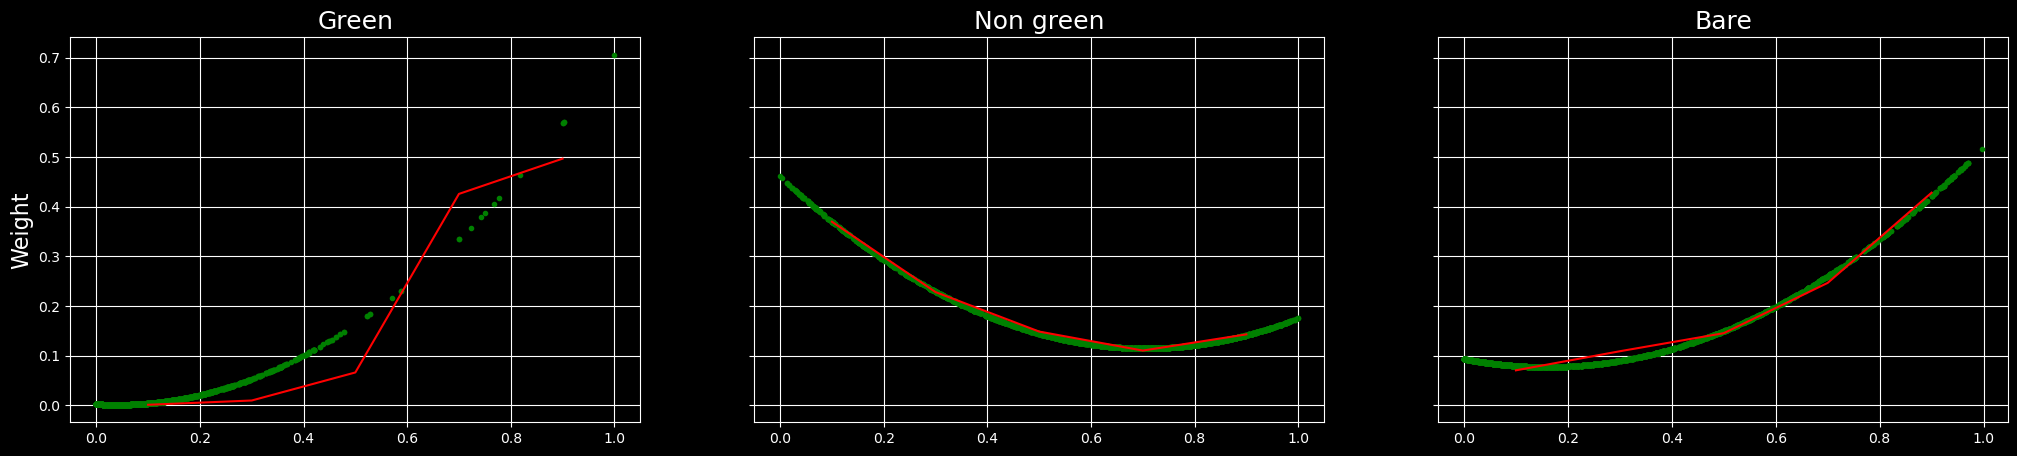

In [232]:
# Weighting by number of points
histoB = np.histogram(totalBareCover,bins=5,range=[0,1])
histoNormB=histoB[0].sum()/histoB[0]
histoNormB /= histoNormB.sum()
bareCoeffs = np.polyfit((histoB[1][1:]+histoB[1][:-1])/2,histoNormB,2)
bareWeights = np.polyval(bareCoeffs,totalBareCover)
if bareWeights.min() < histoNormB.min():
    bareCoeffs[-1] = bareCoeffs[-1] + (histoNormB.min()-bareWeights.min())
    bareWeights = np.polyval(bareCoeffs,totalBareCover)
print(", ".join([f"{coeff:.4f}" for coeff in bareCoeffs]))


# Weighting by number of points
histoG = np.histogram(totalPVCover,bins=5,range=[0,1])
histoNormG=histoG[0].sum()/histoG[0]
histoNormG /= histoNormG.sum()
greenCoeffs = np.polyfit((histoG[1][1:]+histoG[1][:-1])/2,histoNormG,2)
greenWeights = np.polyval(greenCoeffs,totalPVCover)
if greenWeights.min() < histoNormG.min():
    greenCoeffs[-1] = greenCoeffs[-1] + (histoNormG.min()-greenWeights.min())
    greenWeights = np.polyval(greenCoeffs,totalPVCover)
print(", ".join([f"{coeff:.4f}" for coeff in greenCoeffs]))

# Weighting by number of points
histoN = np.histogram(totalNPVCover,bins=5,range=[0,1])
histoNormN=histoN[0].sum()/histoN[0]
histoNormN /= histoNormN.sum()
nonGreenCoeffs = np.polyfit((histoN[1][1:]+histoN[1][:-1])/2,histoNormN,2)
nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)
if nonGreenWeights.min() < histoNormN.min():
    nonGreenCoeffs[-1] = nonGreenCoeffs[-1] + (histoNormN.min()-nonGreenWeights.min())
    nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)
print(", ".join([f"{coeff:.4f}" for coeff in nonGreenCoeffs]))

sampleWeights = np.transpose([bareWeights,greenWeights,nonGreenWeights])

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,greenWeights,'g.',(histoG[1][1:]+histoG[1][:-1])/2,histoNormG, 'r-')
ax2.plot(totalNPVCover,nonGreenWeights,'g.',(histoN[1][1:]+histoN[1][:-1])/2,histoNormN, 'r-')
ax3.plot(totalBareCover,bareWeights,'g.',(histoB[1][1:]+histoB[1][:-1])/2,histoNormB, 'r-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green', fontsize=18)
ax2.set_title('Non green', fontsize=18)
ax3.set_title('Bare', fontsize=18)
ax1.set_ylabel('Weight', fontsize=16)
#plt.savefig('../paper/weights.png', bbox_inches='tight')

### Build a weighted Loss Function using these coefficients



In [233]:
def histogramWeightedLoss(y_true, y_pred):
    # Calculate polynomial weights for each component of y_true
    yWeights = tf.transpose([
        tf.math.polyval([0.6275, -0.2009, 0.0934], y_true[:, 0]),
        tf.math.polyval([0.7642, -0.0604, 0.0024], y_true[:, 1]),
        tf.math.polyval([0.6964, -0.9822, 0.4613], y_true[:, 2])
    ])
    
    # Compute the different components of the loss
    unmixingError = tf.reduce_mean(tf.abs(y_true * yWeights - y_pred * yWeights), axis=-1)
    negativityError = tf.reduce_mean(-y_pred * tf.cast(tf.less(y_pred, 0), tf.float32), axis=1)
    sum2oneError = 0.005 * tf.abs(tf.reduce_sum(y_pred, axis=1) - 1.0)

    # Combine all components into the final loss
    loss = unmixingError + sum2oneError + negativityError
    
    return loss


## Build and Train the model

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,915 (527.01 KB)

 Trainable params: 134,915 (527.01 KB)

 Non-trainable params: 0 (0.00 B)

Training Progress:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training Progress:   9%|▉         | 918/10000 [00:49<07:26, 20.36epoch/s]


Epoch 920: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.


Training Progress:  30%|███       | 3049/10000 [02:38<05:20, 21.70epoch/s]


Epoch 3050: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.


Training Progress:  36%|███▌      | 3550/10000 [03:02<04:54, 21.87epoch/s]


Epoch 3550: ReduceLROnPlateau reducing learning rate to 0.0008573750033974647.


Training Progress:  40%|████      | 4050/10000 [03:30<04:27, 22.26epoch/s]


Epoch 4050: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.


Training Progress:  43%|████▎     | 4293/10000 [03:42<04:55, 19.31epoch/s]

Epoch 4293: early stopping
Restoring model weights from the end of the best epoch: 3293.


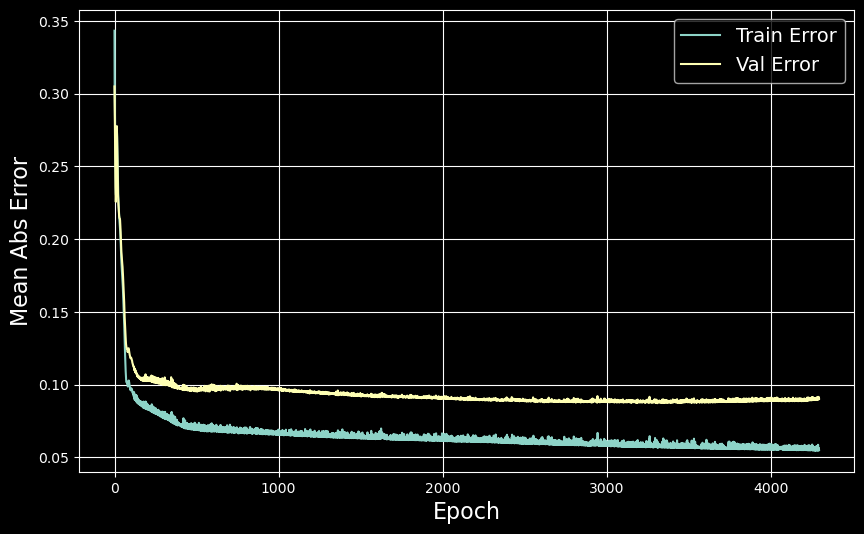

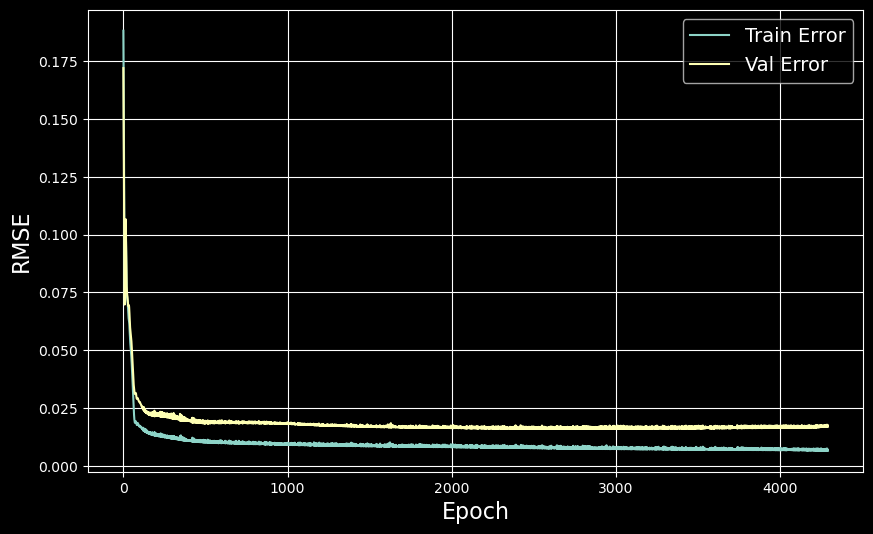

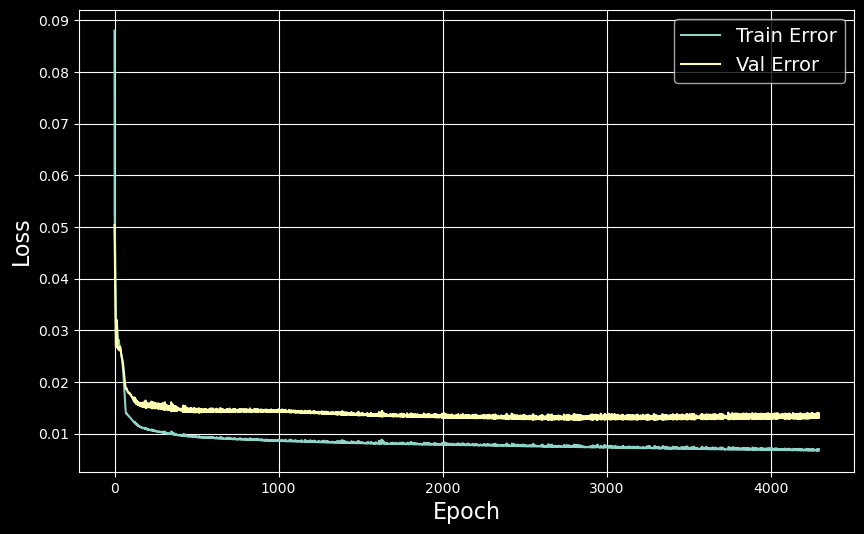

In [234]:
# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()

model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.max_norm(1),input_shape=[train_dataset.shape[1]]),
tf.keras.layers.Dense(256, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1)),
tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.max_norm(1)),
tf.keras.layers.Dense(3)
])


model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['mean_absolute_error', 'mean_squared_error']) 
model.summary()

# Fit the Model 



history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=8192,
                    callbacks=[TQDMProgressBar(),
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000,restore_best_weights=True),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.95,patience=500, verbose=1, min_lr=0.0001)])
print('\n')

# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('Mean Abs Error', fontsize=16)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingMAE.png', bbox_inches='tight', facecolor='w')

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('RMSE', fontsize=16)
  plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingMSE.png', bbox_inches='tight', facecolor='w')

  plt.figure(figsize=(10,6))
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  plt.grid(True)
  plt.legend(fontsize=14)
  #plt.savefig('../paper/trainingLoss.png', bbox_inches='tight', facecolor='w')


plot_history(history)

### Prediction Plots

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



Green RMSE = 0.080025
Non Green RMSE = 0.127750
Bare RMSE = 0.118019

Green MAE = 0.049347
Non Green MAE = 0.094343
Bare MAE = 0.086060

Min Bare = 0.028547
Min Green = 0.005342
Min NonGreen = 0.061204


(0.0, 1.0)

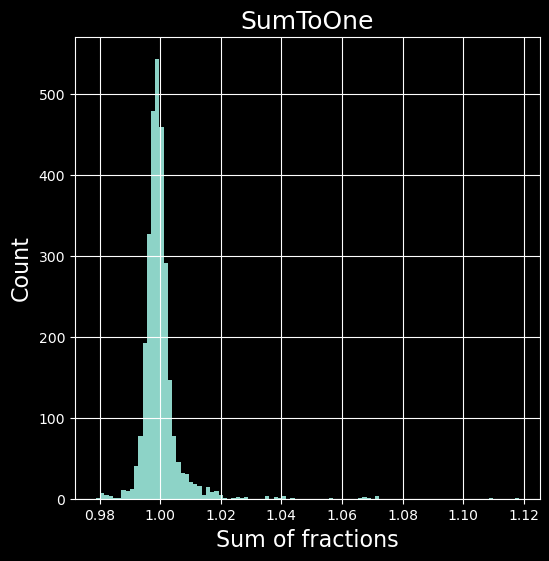

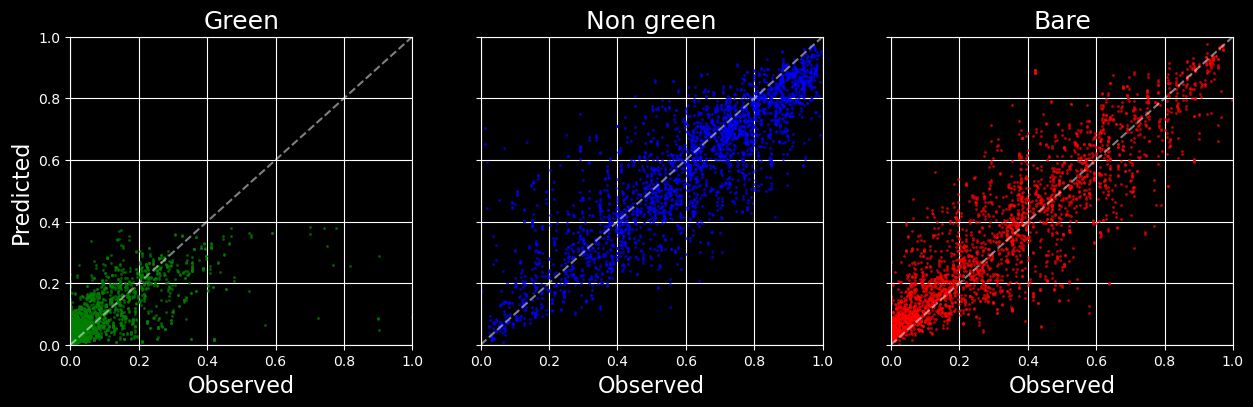

In [236]:
# Predict
allLabels = train_labels
allPredictions = model.predict(train_dataset)

predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "\nGreen RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
# Print some MAE values
print( "\nGreen MAE = %f" % np.mean(np.abs(totalPVCover-predGreenCover)))
print( "Non Green MAE = %f" % np.mean(np.abs(totalNPVCover-predNongreenCover)))
print( "Bare MAE = %f" % np.mean(np.abs(totalBareCover-predBareCover)))
# Print the minimum values
print( "\nMin Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(6,6))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=18)
plt.grid(True)
plt.xlabel('Sum of fractions', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.savefig('../paper/fcSum2one.png', bbox_inches='tight',facecolor='w')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,4),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.75,markeredgewidth=0.0, markersize=2)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.75,markeredgewidth=0.0, markersize=2)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.75,markeredgewidth=0.0, markersize=2)
# Plot 1:1 lines
ax1.plot([0, 1], [0, 1], 'w--',alpha=0.5)
ax2.plot([0, 1], [0, 1], 'w--',alpha=0.5)
ax3.plot([0, 1], [0, 1], 'w--',alpha=0.5)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green', fontsize=18)
ax2.set_title('Non green', fontsize=18)
ax3.set_title('Bare', fontsize=18)
ax1.set_xlabel('Observed', fontsize=16)
ax2.set_xlabel('Observed', fontsize=16)
ax3.set_xlabel('Observed', fontsize=16)
ax1.set_ylabel('Predicted', fontsize=16)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
#f.savefig('../paper/fcCalibration.png', bbox_inches='tight',facecolor='w')

